In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

# **Mapping Classes to Data**

In [2]:
df = pd.read_csv("D:/Major project/dataset/train.csv")

diagnosis_classes = {
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df["type"] = df["diagnosis"].map(diagnosis_classes.get)

# **Data Visualization**

In [4]:
df.head()

,id_code,diagnosis,type
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferate_DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,None
4,005b95c28852,0,None


<AxesSubplot:>

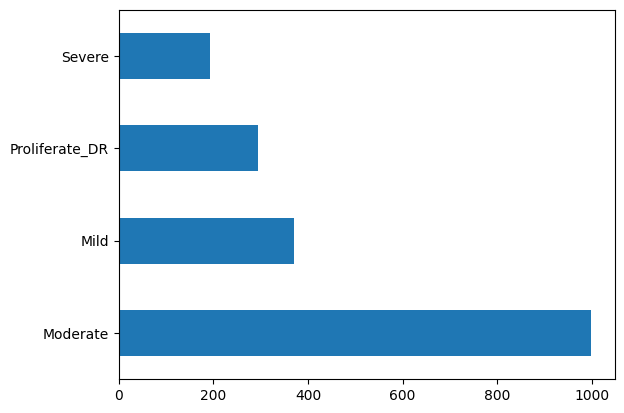

In [5]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

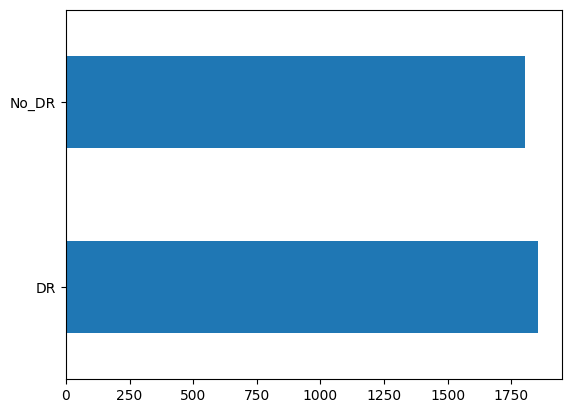

In [6]:
df['binary'].value_counts().plot(kind='barh')

# **Data Preprocessing**

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from imutils import paths
from sklearn.utils import shuffle

>***Gathering Images and Lables***

In [4]:
data = []
labels = []
width,height=224,224

imagePaths = list(paths.list_images('D:/Major project/dataset/gaussian_filtered_images'))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

(1544, 224, 224, 3)
(1544, 4)


>***Normalizing the Data***

In [5]:
data = data / 255.0

# **Splitting Data to Training , Validatoin and Testing Sets**

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (1235, 224, 224, 3)
Test images: (309, 224, 224, 3)
Train label: (1235, 4)
Test label: (309, 4)


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_val.shape)
print("Train label:",y_train.shape)
print("Test label:",y_val.shape)

Train images: (988, 224, 224, 3)
Test images: (247, 224, 224, 3)
Train label: (988, 4)
Test label: (247, 4)


# **Preparing VGG16 Pretrained Model**

In [8]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras import layers

In [9]:
Vgg16 = VGG16(include_top=False, input_shape= (224,224,3)) 

Vgg16.trainable=False

# **Fine-Tuning VGG16**

In [13]:
model = Sequential()
model.add(Vgg16)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64 , activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(4 , activation="softmax"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy" )

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [41]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(x_train , y_train , epochs=100 , batch_size=32,
                    validation_data=(x_val,y_val), verbose=1)

Epoch 1/100
31/31 [==============================] - 229s 7s/step - loss: 0.4917 - binary_accuracy: 0.7801 - val_loss: 0.4937 - val_binary_accuracy: 0.7844
Epoch 2/100
31/31 [==============================] - 229s 7s/step - loss: 0.4881 - binary_accuracy: 0.7804 - val_loss: 0.4914 - val_binary_accuracy: 0.7864
Epoch 3/100
31/31 [==============================] - 228s 7s/step - loss: 0.4901 - binary_accuracy: 0.7804 - val_loss: 0.4905 - val_binary_accuracy: 0.7935
Epoch 4/100
31/31 [==============================] - 227s 7s/step - loss: 0.4828 - binary_accuracy: 0.7826 - val_loss: 0.4951 - val_binary_accuracy: 0.7874
Epoch 5/100
31/31 [==============================] - 228s 7s/step - loss: 0.4810 - binary_accuracy: 0.7864 - val_loss: 0.5081 - val_binary_accuracy: 0.7814
Epoch 6/100
31/31 [==============================] - 227s 7s/step - loss: 0.4773 - binary_accuracy: 0.7849 - val_loss: 0.4876 - val_binary_accuracy: 0.7955
Epoch 7/100
31/31 [==============================] - 227s 7s/ste

In [42]:
model.save('model_vgg_new_data.h5')

In [19]:
from keras.models import load_model

# Load the model
model = load_model('model_vgg_new_data.h5')



# **Evaluating the Model Performene**

In [44]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

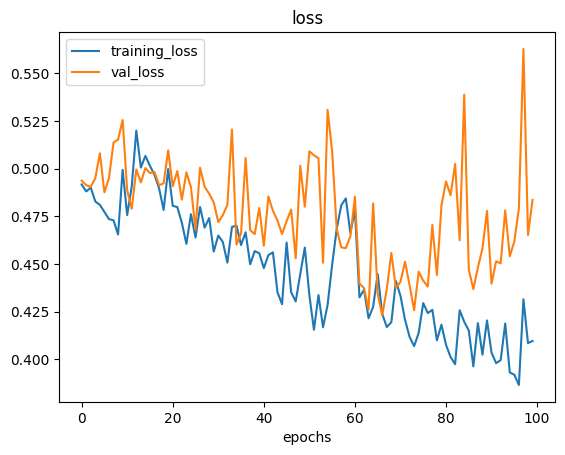

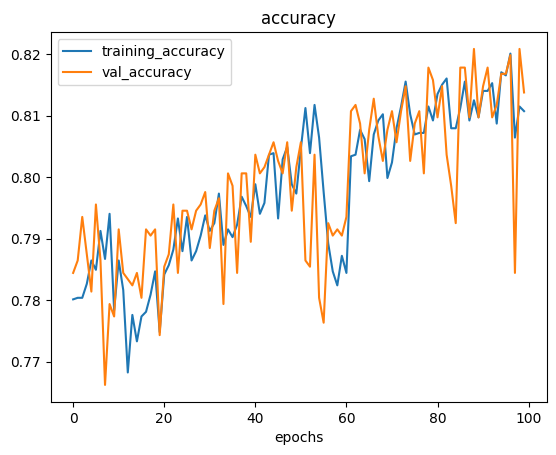

In [45]:
plot_curves(history)

> **Predicting Test Set**

In [20]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

10/10 [==============================] - 19s 2s/step


# ***Visualizing a prediction***

[0 0 0 1]
Prediction: Severe


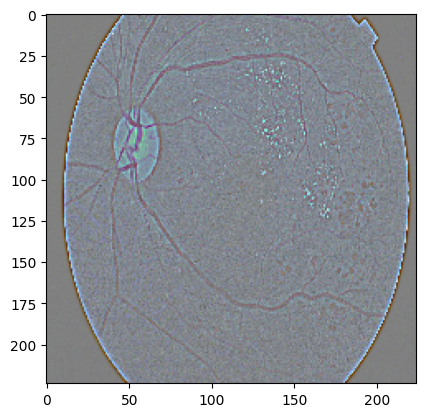

In [21]:
index =15
predictions=["Mild","Moderate","Proliferate_DR","Severe"] 

img = x_test[index]
RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
RGBImg= cv2.resize(RGBImg,(224,224))

plt.imshow(RGBImg)
print(y_test[index]) # true
print(f"Prediction: {predictions[pred[index]]}") # predicted  

# **Predicting a new Sample**

In [22]:
import cv2

def predict_new(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

1/1 [==============================] - 0s 152ms/step
Predicted: Severe


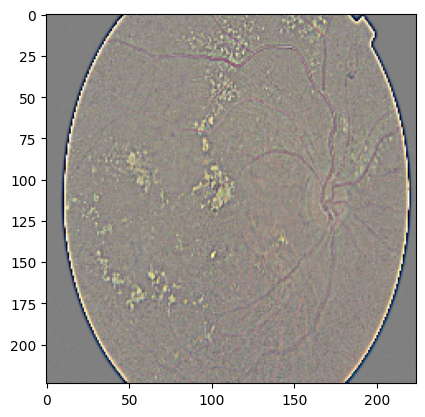

In [28]:
predict_new(r"data\gaussian_filtered_images\gaussian_filtered_images\sev1.png")


In [18]:
y_pred = []
for i in y_test:
    k=0
    for j in i:
        if j==1:
            y_pred.append(predictions[k])
        else:k=k+1
print(y_pred)
print(y_test.shape, len(y_pred))

['Proliferate_DR', 'Proliferate_DR', 'Moderate', 'Severe', 'Mild', 'Moderate', 'Severe', 'Severe', 'Moderate', 'Severe', 'Mild', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Mild', 'Proliferate_DR', 'Moderate', 'Severe', 'Mild', 'Proliferate_DR', 'Severe', 'Severe', 'Mild', 'Proliferate_DR', 'Moderate', 'Moderate', 'Severe', 'Moderate', 'Moderate', 'Proliferate_DR', 'Proliferate_DR', 'Severe', 'Mild', 'Severe', 'Mild', 'Mild', 'Moderate', 'Severe', 'Severe', 'Proliferate_DR', 'Severe', 'Mild', 'Severe', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR', 'Moderate', 'Mild', 'Severe', 'Proliferate_DR', 'Proliferate_DR', 'Proliferate_DR', 'Severe', 'Mild', 'Severe', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR', 'Mild', 'Mild', 'Severe', 'Moderate', 'Proliferate_DR', 'Severe', 'Mild', 'Severe', 'Moderate', 'Proliferate_DR', 'Moderate', 'Moderate', 'Proliferate_DR', 'Severe', 'Proliferate_DR', 'Proliferate_DR', 'Proliferate_DR', 'Proliferate_DR', 'Severe', 'Moderate', 'Mild', 'Moderate',

In [19]:
preds = []
for i in pred:
    preds.append(predictions[i])
print(preds)

['Moderate', 'Severe', 'Moderate', 'Severe', 'Mild', 'Moderate', 'Severe', 'Severe', 'Moderate', 'Moderate', 'Mild', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Proliferate_DR', 'Severe', 'Mild', 'Moderate', 'Severe', 'Severe', 'Mild', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Severe', 'Mild', 'Severe', 'Mild', 'Mild', 'Moderate', 'Proliferate_DR', 'Severe', 'Moderate', 'Severe', 'Mild', 'Severe', 'Mild', 'Moderate', 'Severe', 'Moderate', 'Moderate', 'Mild', 'Severe', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Severe', 'Mild', 'Moderate', 'Moderate', 'Moderate', 'Mild', 'Mild', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Mild', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Severe', 'Moderate', 'Moderate', 'Moderate', 'Severe', 'Severe', 'Moderate', 'Mild', 'Moderate', 'Moderate', 'Severe', 'Severe', 'Mild', 'Moderate', 'Proliferate_DR', 'Moderate', 'Seve

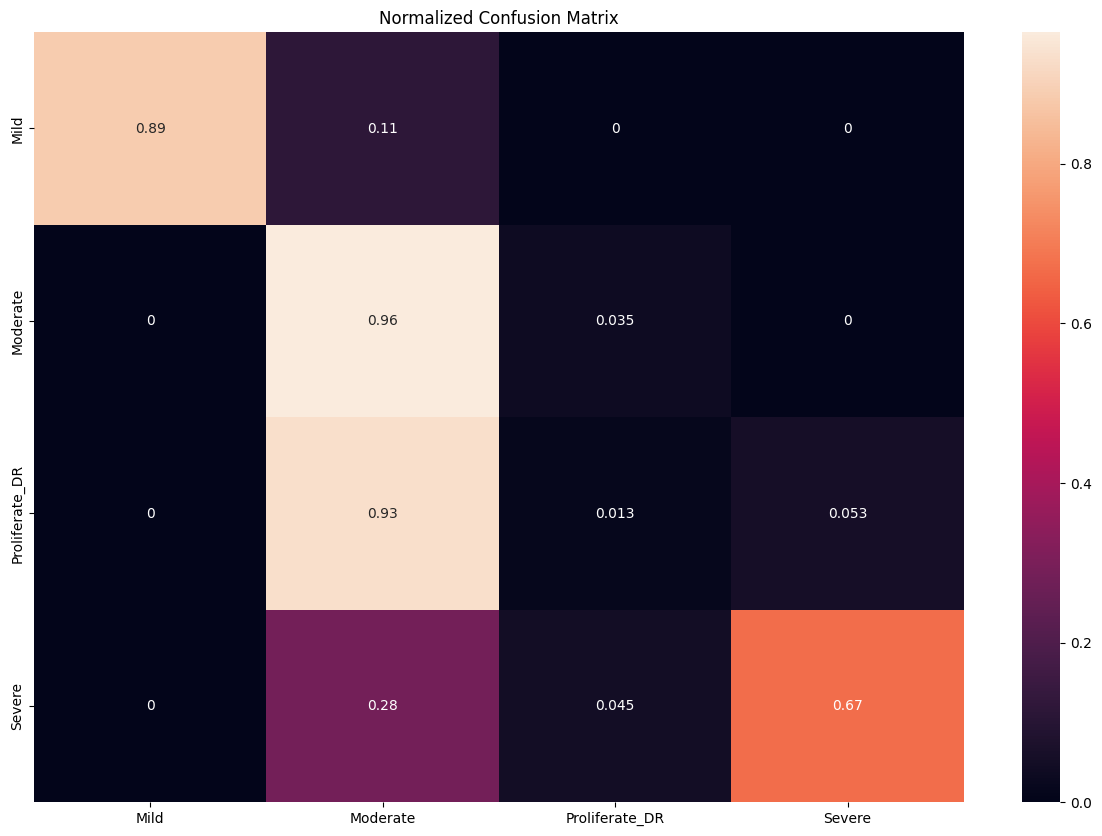

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_pred, preds, normalize='true')
plt.figure(figsize = (15, 10))
sns.heatmap(cf_matrix, annot=True, xticklabels=predictions, yticklabels=predictions)
plt.title('Normalized Confusion Matrix')
plt.show()